# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 32
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

In [8]:
element_gameweek_df['row_id'] = element_gameweek_df['row_id'].rank()

In [9]:
element_gameweek_df['element_fixture_rank'] = element_gameweek_df.groupby('element')['row_id'].rank()

In [10]:
element_gameweek_df

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,team_a_difficulty,team_h,team_h_difficulty,element_type,team,web_name,safe_web_name,own_team,opposition_team,element_fixture_rank
80,1.0,0,92,0,0,0,11,0,6,85,...,2,16,4,2,1,Koscielny,koscielny,1,16,1.0
82,2.0,0,74,0,0,0,17,0,4,70,...,2,3,4,2,1,Koscielny,koscielny,1,3,2.0
83,3.0,0,38,0,0,0,10,0,2,36,...,5,12,4,2,1,Koscielny,koscielny,1,12,3.0
84,4.0,0,64,0,0,0,19,0,10,57,...,4,1,2,2,1,Koscielny,koscielny,1,9,4.0
85,5.0,0,89,0,0,0,17,0,2,87,...,3,19,4,2,1,Koscielny,koscielny,1,19,5.0
86,6.0,0,32,0,1,3,41,1,17,27,...,4,1,4,2,1,Koscielny,koscielny,1,6,6.0
88,7.0,0,36,0,0,0,26,0,10,32,...,5,13,4,2,1,Koscielny,koscielny,1,13,7.0
89,8.0,0,41,0,0,1,25,0,14,37,...,2,10,4,2,1,Koscielny,koscielny,1,10,8.0
90,9.0,0,17,0,0,0,3,0,2,15,...,4,1,2,2,1,Koscielny,koscielny,1,16,9.0
91,10.0,0,69,0,0,1,30,0,8,65,...,4,1,2,2,1,Koscielny,koscielny,1,2,10.0


In [11]:
rolling_df = \
element_gameweek_df.copy().groupby('element', as_index=True)[['minutes', 'goals_scored', 'assists']]\
.rolling(38, min_periods=1).sum().reset_index()[['element', 'minutes', 'goals_scored', 'assists']]

In [12]:
rolling_df['element_fixture_rank'] = rolling_df.groupby('element')['minutes'].rank()

In [13]:
rolling_df.head()

,element,minutes,goals_scored,assists,element_fixture_rank
0,3,90.0,0.0,0.0,1.0
1,3,159.0,0.0,0.0,2.0
2,3,204.0,0.0,0.0,3.0
3,3,294.0,0.0,0.0,4.0
4,3,384.0,0.0,0.0,5.0


In [14]:
rolling_df['element_fixture_rank'] = rolling_df['element_fixture_rank'] + 1

In [15]:
element_gameweek_df =\
element_gameweek_df.join(
    rolling_df.set_index(['element', 'element_fixture_rank']),
    on=['element', 'element_fixture_rank'],
    rsuffix='_rolling')

In [16]:
element_gameweek_df['goals_scored_per_minute_rolling'] = \
element_gameweek_df['goals_scored_rolling'] / element_gameweek_df['minutes_rolling']

element_gameweek_df['assists_per_minute_rolling'] = \
element_gameweek_df['assists_rolling'] / element_gameweek_df['minutes_rolling']

element_gameweek_df['minutes_per_fixture_rolling'] = \
element_gameweek_df['minutes_rolling'] / element_gameweek_df['element_fixture_rank']

In [17]:
element_gameweek_df.head()

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,safe_web_name,own_team,opposition_team,element_fixture_rank,minutes_rolling,goals_scored_rolling,assists_rolling,goals_scored_per_minute_rolling,assists_per_minute_rolling,minutes_per_fixture_rolling
80,1.0,0,92,0,0,0,11,0,6,85,...,koscielny,1,16,1.0,NaN,NaN,NaN,NaN,NaN,NaN
82,2.0,0,74,0,0,0,17,0,4,70,...,koscielny,1,3,2.0,90.0,0.0,0.0,0.0,0.0,45.0
83,3.0,0,38,0,0,0,10,0,2,36,...,koscielny,1,12,3.0,159.0,0.0,0.0,0.0,0.0,53.0
84,4.0,0,64,0,0,0,19,0,10,57,...,koscielny,1,9,4.0,204.0,0.0,0.0,0.0,0.0,51.0
85,5.0,0,89,0,0,0,17,0,2,87,...,koscielny,1,19,5.0,294.0,0.0,0.0,0.0,0.0,58.8


# Models

## Simple Poisson model

### Preparing data

In [18]:
spm_df = element_gameweek_df.copy()

In [19]:
spm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [20]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [21]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'goals_scored')

In [22]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [23]:
spm_response_df.head()

80    0
82    0
83    0
84    0
85    0
Name: goals_scored, dtype: int64

### Fitting model

In [24]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [25]:
print(spm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8160
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2893.8
Date:                Mon, 08 Apr 2019   Deviance:                       4175.4
Time:                        15:16:39   Pearson chi2:                 9.23e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2352      0.034    -66.042      0.000      -2.302      -2.169


### Model fit

In [26]:
spm_results.aic

5789.631849369688

In [27]:
spm_results.bic

-69322.66552575112

In [28]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(True, 3.3306690738754696e-16)

In [29]:
spm_results.resid_deviance.describe()

count    8161.000000
mean       -0.248799
std         0.670663
min        -0.462541
25%        -0.462541
50%        -0.462541
75%        -0.462541
max         3.770509
dtype: float64

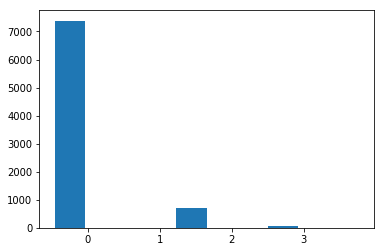

In [30]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Poisson minutes model

### Preparing data

In [31]:
spmm_df = element_gameweek_df.copy()

In [32]:
spmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [33]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [34]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [35]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'goals_scored')

In [36]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [37]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [38]:
print(spmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8159
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2835.0
Date:                Mon, 08 Apr 2019   Deviance:                       4057.8
Time:                        15:16:40   Pearson chi2:                 9.09e+03
No. Iterations:                     6                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.7064      0.292    -16.110      0.000      -5.279      -4.134
log_minutes     0.5904      0.067      8.749     

### Model fit

In [39]:
spmm_results.aic

5673.99409973864

In [40]:
spmm_results.bic

-69431.2961533927

In [41]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(True, 1.177502539917441e-12)

In [42]:
spmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.241518
std         0.662528
min        -0.507525
25%        -0.507525
50%        -0.507525
75%        -0.347720
max         3.782517
dtype: float64

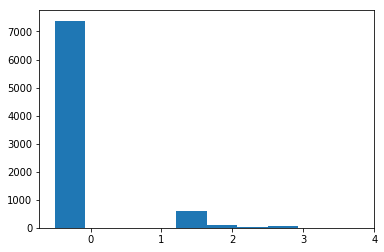

In [43]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Poisson exposure model

### Preparing data

In [44]:
epmm_df = element_gameweek_df.copy()

In [45]:
epmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [46]:
epmm_exposure = epmm_df['minutes']

In [47]:
epmm_df = player.remove_redundant_columns(epmm_df, epmm_redundant_columns)

In [48]:
epmm_response_df, epmm_explanatory_df = player.get_response_explanatory_dfs(epmm_df, 'goals_scored')

In [49]:
epmm_explanatory_df.columns

Index(['const'], dtype='object')

### Fitting model

In [50]:
epmm_results = sm.GLM(
    epmm_response_df,
    epmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=epmm_exposure
).fit()

In [51]:
print(epmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8160
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2849.7
Date:                Mon, 08 Apr 2019   Deviance:                       4087.1
Time:                        15:16:40   Pearson chi2:                 1.16e+04
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4841      0.034   -191.584      0.000      -6.550      -6.418


### Model fit

In [52]:
epmm_results.aic

5701.314817635959

In [53]:
epmm_results.bic

-69410.98255748485

In [54]:
epmm_pearson_results = goodness_fit.pearson_chi_squared_test(epmm_results)
epmm_pearson_results

(True, 0.0)

In [55]:
epmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.231700
std         0.668717
min        -0.524352
25%        -0.524352
50%        -0.524352
75%        -0.276358
max         3.839107
dtype: float64

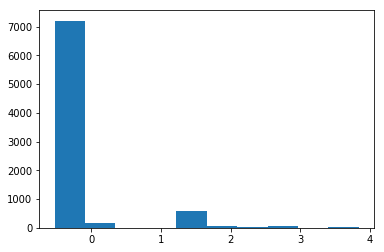

In [56]:
plt.figure()
plt.hist(epmm_results.resid_deviance)
plt.show()

## Simple Poisson teams model

### Preparing data

In [57]:
sptm_df = element_gameweek_df.copy()

In [58]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [59]:
sptm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [60]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [61]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'goals_scored')

In [62]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [63]:
sptm_response_df.head()

80    0
82    0
83    0
84    0
85    0
Name: goals_scored, dtype: int64

### Fitting model

In [64]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [65]:
print(sptm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8119
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2643.5
Date:                Mon, 08 Apr 2019   Deviance:                       3674.8
Time:                        15:16:41   Pearson chi2:                 8.95e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.1530      0.232    -13.580      0.000      -3.608      -2.698
was_home               0.237

### Model fit

In [66]:
sptm_results.aic

5370.946789851232

In [67]:
sptm_results.bic

-69454.05858370135

In [68]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(True, 1.0546985507176032e-10)

In [69]:
sptm_results.resid_deviance.describe()

count    8161.000000
mean       -0.223506
std         0.632754
min        -1.219853
25%        -0.505318
50%        -0.369162
75%        -0.255569
max         3.653811
dtype: float64

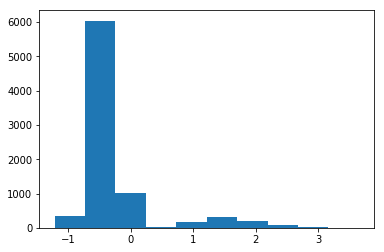

In [70]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Poisson teams minutes model

### Preparing data

In [71]:
sptmm_df = element_gameweek_df.copy()

In [72]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [73]:
sptmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [74]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [75]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [76]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'goals_scored')

In [77]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [78]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [79]:
print(sptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8118
Model Family:                 Poisson   Df Model:                           42
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2522.1
Date:                Mon, 08 Apr 2019   Deviance:                       3432.0
Time:                        15:16:42   Pearson chi2:                 1.01e+04
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.0834      0.409    -17.332      0.000      -7.884      -6.282
was_home               0.226

### Model fit

In [80]:
sptmm_results.aic

5130.165637069073

In [81]:
sptmm_results.bic

-69687.83261449402

In [82]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(True, 0.0)

In [83]:
sptmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.211179
std         0.613176
min        -1.419982
25%        -0.481967
50%        -0.328398
75%        -0.226089
max         3.535034
dtype: float64

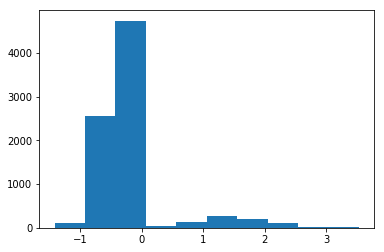

In [84]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Poisson teams exposure model

### Preparing data

In [85]:
eptmm_df = element_gameweek_df.copy()

In [86]:
eptmm_df = player.add_categorical_variables(eptmm_df, 'element_type')
eptmm_df = player.add_categorical_variables(eptmm_df, 'opposition_team')
eptmm_df = player.add_categorical_variables(eptmm_df, 'own_team')

In [87]:
eptmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [88]:
eptmm_exposure = eptmm_df['minutes']

In [89]:
eptmm_df = player.remove_redundant_columns(eptmm_df, eptmm_redundant_columns)

In [90]:
eptmm_response_df, eptmm_explanatory_df = player.get_response_explanatory_dfs(eptmm_df, 'goals_scored')

In [91]:
eptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

### Fitting model

In [92]:
eptmm_results = sm.GLM(
    eptmm_response_df,
    eptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eptmm_exposure
).fit()

In [93]:
print(eptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     8119
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2523.1
Date:                Mon, 08 Apr 2019   Deviance:                       3434.0
Time:                        15:16:43   Pearson chi2:                 1.15e+04
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.5760      0.232    -32.632      0.000      -8.031      -7.121
was_home               0.225

### Model fit

In [94]:
eptmm_results.aic

5130.192616669883

In [95]:
eptmm_results.bic

-69694.81275688269

In [96]:
eptmm_pearson_results = goodness_fit.pearson_chi_squared_test(eptmm_results)
eptmm_pearson_results

(True, 0.0)

In [97]:
eptmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.208521
std         0.614287
min        -1.439796
25%        -0.481759
50%        -0.322687
75%        -0.219356
max         3.673583
dtype: float64

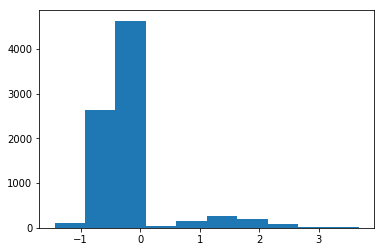

In [98]:
plt.figure()
plt.hist(eptmm_results.resid_deviance)
plt.show()

## Simple Poisson teams form exposure model

### Preparing data

In [179]:
eptmmf_df = element_gameweek_df.copy()

In [180]:
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'element_type')
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'opposition_team')
eptmmf_df = player.add_categorical_variables(eptmmf_df, 'own_team')

In [181]:
eptmmf_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
]

In [182]:
eptmmf_exposure = eptmmf_df['minutes']

In [183]:
eptmmf_df = player.remove_redundant_columns(eptmmf_df, eptmmf_redundant_columns)

In [184]:
eptmmf_response_df, eptmmf_explanatory_df = player.get_response_explanatory_dfs(eptmmf_df, 'goals_scored')

In [185]:
eptmmf_explanatory_df.columns

Index(['const', 'was_home', 'goals_scored_per_minute_rolling',
       'assists_per_minute_rolling', 'minutes_per_fixture_rolling',
       'element_type_3', 'element_type_4', 'opposition_team_2',
       'opposition_team_3', 'opposition_team_4', 'opposition_team_5',
       'opposition_team_6', 'opposition_team_7', 'opposition_team_8',
       'opposition_team_9', 'opposition_team_10', 'opposition_team_11',
       'opposition_team_12', 'opposition_team_13', 'opposition_team_14',
       'opposition_team_15', 'opposition_team_16', 'opposition_team_17',
       'opposition_team_18', 'opposition_team_19', 'opposition_team_20',
       'own_team_2', 'own_team_3', 'own_team_4', 'own_team_5', 'own_team_6',
       'own_team_7', 'own_team_8', 'own_team_9', 'own_team_10', 'own_team_11',
       'own_team_12', 'own_team_13', 'own_team_14', 'own_team_15',
       'own_team_16', 'own_team_17', 'own_team_18', 'own_team_19',
       'own_team_20'],
      dtype='object')

### Fitting model

In [186]:
eptmmf_results = sm.GLM(
    eptmmf_response_df,
    eptmmf_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eptmmf_exposure
).fit()

In [187]:
print(eptmmf_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 7702
Model:                            GLM   Df Residuals:                     7657
Model Family:                 Poisson   Df Model:                           44
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2406.4
Date:                Mon, 08 Apr 2019   Deviance:                       3262.5
Time:                        15:20:59   Pearson chi2:                 1.11e+04
No. Iterations:                    10                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -7.9220      0.279    -28.443      0.000      -8.468  

### Model fit

In [188]:
eptmmf_results.aic

4902.8002682250535

In [189]:
eptmmf_results.bic

-65261.83535807837

In [190]:
eptmmf_pearson_results = goodness_fit.pearson_chi_squared_test(eptmmf_results)
eptmmf_pearson_results

(True, 0.0)

In [191]:
eptmmf_results.resid_deviance.describe()

count    7702.000000
mean       -0.208833
std         0.616461
min        -1.743620
25%        -0.483023
50%        -0.323288
75%        -0.220497
max         3.678239
dtype: float64

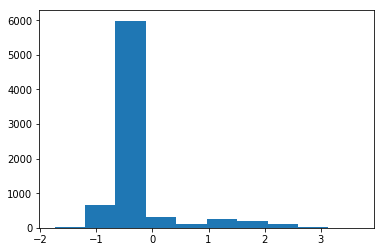

In [192]:
plt.figure()
plt.hist(eptmmf_results.resid_deviance)
plt.show()

## Simple Poisson player model

### Preparing data

In [113]:
sppm_df = element_gameweek_df.copy()

In [114]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [115]:
sppm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [116]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [117]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'goals_scored')

In [118]:
sppm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=479)

### Fitting model

In [119]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [120]:
print(sppm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7682
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2241.5
Date:                Mon, 08 Apr 2019   Deviance:                       2870.8
Time:                        15:17:01   Pearson chi2:                 5.55e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6154      0.604     -2.676      0.007      -2.798      -0.432
was_home               0.247

### Model fit

In [121]:
sppm_results.aic

5440.939998106251

In [122]:
sppm_results.bic

-66321.95306604827

In [123]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(False, 1.0)

In [124]:
sppm_results.resid_deviance.describe()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


count    8160.000000
mean       -0.156868
std         0.572050
min        -1.573389
25%        -0.460430
50%        -0.276559
75%        -0.000001
max         3.205020
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


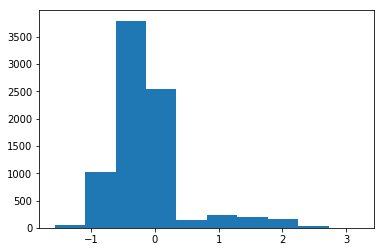

In [125]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Poisson player minutes model

### Preparing data

In [126]:
sppmm_df = element_gameweek_df.copy()

In [127]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [128]:
sppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [129]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [130]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [131]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'goals_scored')

In [132]:
sppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_593', 'element_594', 'element_599', 'element_601',
       'element_602', 'element_603', 'element_605', 'element_607',
       'element_608', 'log_minutes'],
      dtype='object', length=480)

### Fitting model

In [133]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [134]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7681
Model Family:                 Poisson   Df Model:                          479
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2190.2
Date:                Mon, 08 Apr 2019   Deviance:                       2768.3
Time:                        15:17:17   Pearson chi2:                 6.06e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.7734      0.709     -6.736      0.000      -6.162      -3.385
was_home               0.221

### Model fit

In [135]:
sppmm_results.aic

5340.434027748107

In [136]:
sppmm_results.bic

-66415.45191441693

In [137]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(False, 1.0)

In [138]:
sppmm_results.resid_deviance.describe()

count    8160.000000
mean       -0.152287
std         0.562222
min        -1.434722
25%        -0.444309
50%        -0.258004
75%        -0.000001
max         3.231651
dtype: float64

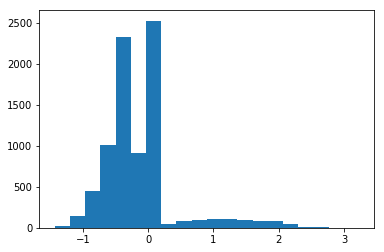

In [139]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Poisson player exposure model

### Preparing data

In [140]:
eppmm_df = element_gameweek_df.copy()

In [141]:
eppmm_df = player.add_categorical_variables(eppmm_df, 'opposition_team')
eppmm_df = player.add_categorical_variables(eppmm_df, 'element')

In [142]:
eppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes', 'element_fixture_rank',
    'minutes_rolling', 'goals_scored_rolling', 'assists_rolling',
    'goals_scored_per_minute_rolling', 'assists_per_minute_rolling', 'minutes_per_fixture_rolling'
]

In [143]:
eppmm_exposure = eppmm_df['minutes']

In [144]:
eppmm_df = player.remove_redundant_columns(eppmm_df, eppmm_redundant_columns)

In [145]:
eppmm_response_df, eppmm_explanatory_df = player.get_response_explanatory_dfs(eppmm_df, 'goals_scored')

In [146]:
eppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=479)

### Fitting model

In [147]:
eppmm_results = sm.GLM(
    eppmm_response_df,
    eppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eppmm_exposure
).fit()

In [148]:
print(eppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 8161
Model:                            GLM   Df Residuals:                     7682
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2195.1
Date:                Mon, 08 Apr 2019   Deviance:                       2778.0
Time:                        15:17:35   Pearson chi2:                 7.91e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.9973      0.604     -9.936      0.000      -7.180      -4.814
was_home               0.217

### Model fit

In [149]:
eppmm_results.aic

5348.141962792908

In [150]:
eppmm_results.bic

-66414.75110136162

In [151]:
eppmm_pearson_results = goodness_fit.pearson_chi_squared_test(eppmm_results)
eppmm_pearson_results

(True, 0.034988645970658094)

In [152]:
eppmm_results.resid_deviance.describe()

count    8160.000000
mean       -0.148268
std         0.564351
min        -1.441568
25%        -0.437792
50%        -0.248244
75%        -0.000001
max         3.591296
dtype: float64

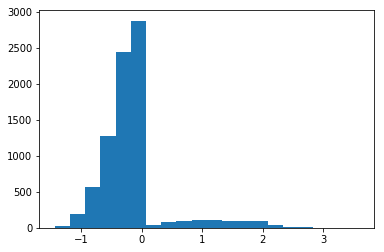

In [153]:
plt.figure()
plt.hist(eppmm_results.resid_deviance, bins=20)
plt.show()

# Model comparison

In [193]:
aic = {
    'Simple Poisson': spm_results.aic,
    'Poisson teams': sptm_results.aic,
    'Poisson players': sppm_results.aic,
    
    'Simple Poisson minutes': spmm_results.aic,
    'Simple Poisson exposure': epmm_results.aic,
    'Poisson teams minutes': sptmm_results.aic,
    'Poisson teams exposure': eptmm_results.aic,
    'Poisson teams exposure form': eptmmf_results.aic,
    'Poisson players minutes': sppmm_results.aic,
    'Poisson players exposure': eppmm_results.aic,
    }
aic

{'Simple Poisson': 5789.631849369688,
 'Poisson teams': 5370.946789851232,
 'Poisson players': 5440.939998106251,
 'Simple Poisson minutes': 5673.99409973864,
 'Simple Poisson exposure': 5701.314817635959,
 'Poisson teams minutes': 5130.165637069073,
 'Poisson teams exposure': 5130.192616669883,
 'Poisson teams exposure form': 4902.8002682250535,
 'Poisson players minutes': 5340.434027748107,
 'Poisson players exposure': 5348.141962792908}

In [194]:
bic = {
    'Simple Poisson': spm_results.bic,
    'Poisson teams': sptm_results.bic,
    'Poisson players': sppm_results.bic,
    
    'Simple Poisson minutes': spmm_results.bic,
    'Simple Poisson exposure': epmm_results.bic,
    'Poisson teams minutes': sptmm_results.bic,
    'Poisson teams exposure': eptmm_results.bic,
    'Poisson teams exposure form': eptmmf_results.bic,
    'Poisson players minutes': sppmm_results.bic,
    'Poisson players exposure': eppmm_results.bic,
    }
bic

{'Simple Poisson': -69322.66552575112,
 'Poisson teams': -69454.05858370135,
 'Poisson players': -66321.95306604827,
 'Simple Poisson minutes': -69431.2961533927,
 'Simple Poisson exposure': -69410.98255748485,
 'Poisson teams minutes': -69687.83261449402,
 'Poisson teams exposure': -69694.81275688269,
 'Poisson teams exposure form': -65261.83535807837,
 'Poisson players minutes': -66415.45191441693,
 'Poisson players exposure': -66414.75110136162}

In [196]:
comp_df = pd.DataFrame([
    aic,
    bic
]).T
comp_df.columns = [
    'AIC',
    'BIC'
]
comp_df.astype('int64')

,AIC,BIC
Poisson players,5440,-66321
Poisson players exposure,5348,-66414
Poisson players minutes,5340,-66415
Poisson teams,5370,-69454
Poisson teams exposure,5130,-69694
Poisson teams exposure form,4902,-65261
Poisson teams minutes,5130,-69687
Simple Poisson,5789,-69322
Simple Poisson exposure,5701,-69410
Simple Poisson minutes,5673,-69431
